Aircraft Engine Predictive Maintenance
RUL Regression + Temporal TreeSHAP Explainability

IMPORT LIBRARIES

In [1]:
# 📌 Step 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Ignore warnings
import warnings
warnings.filterwarnings('ignore')

LOAD DATASETS

In [2]:
# 📌 Step 2: Load CSVs (fresh load to avoid merge issues)

train_df = pd.read_csv("C:/Users/Priya  Dharshini/OneDrive/Desktop/PM_train.csv")
test_df = pd.read_csv("C:/Users/Priya  Dharshini/OneDrive/Desktop/PM_test.csv")
rul_df = pd.read_csv("C:/Users/Priya  Dharshini/OneDrive/Desktop/PM_truth.csv")


# Quick check
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Columns:", train_df.columns.tolist())

Train shape: (20631, 26)
Test shape: (13096, 26)
Columns: ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


GENERATE RUL LABELS

In [3]:
# 📌 Step 3: Generate RUL labels (Training and Test sets)
RUL_CAP = 130

# --- 1️⃣ Training set RUL ---
# Drop old columns if rerunning
for col in ['max_cycle','RUL']:
    if col in train_df.columns:
        train_df.drop(columns=[col], inplace=True)

# Compute max cycle per engine
max_cycle_train = train_df.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id', 'max_cycle']

# Merge max_cycle into train_df
train_df = train_df.merge(max_cycle_train, on='id', how='left')

# Compute RUL and cap
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CAP)

# Drop duplicate columns if any
train_df = train_df.loc[:, ~train_df.columns.duplicated()]

# --- 2️⃣ Test set RUL ---
# Drop old columns if rerunning
for col in ['max_cycle','RUL_truth']:
    if col in test_df.columns:
        test_df.drop(columns=[col], inplace=True)

# Compute max cycle per engine
max_cycle_test = test_df.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id', 'max_cycle']
test_df = test_df.merge(max_cycle_test, on='id', how='left')

# --- Handle PM_truth.csv with 2 columns ---
# Usually the second column is the true RUL
rul_df = rul_df.iloc[:, 1].to_frame()  # keep only second column
rul_df.columns = ['RUL_truth']

# Add engine IDs (same order as test engines)
rul_df['id'] = max_cycle_test['id'].values

# Merge RUL_truth into test_df
test_df = test_df.merge(rul_df, on='id', how='left')

# Drop duplicate columns if any
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

# --- 3️⃣ Quick check ---
print("Training set columns:", train_df.columns.tolist())
print("Test set columns:", test_df.columns.tolist())
print("Training RUL range:", train_df['RUL'].min(), "to", train_df['RUL'].max())
print("Test RUL_truth range:", test_df['RUL_truth'].min(), "to", test_df['RUL_truth'].max()) 

Training set columns: ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'max_cycle', 'RUL']
Test set columns: ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'max_cycle', 'RUL_truth']
Training RUL range: 0 to 130
Test RUL_truth range: 7 to 145


In [4]:
# =========================================================
# 📌 Step 4 (New): Add Trend / Slope Features
# =========================================================
window_size = 20

# Select numeric sensor columns (skip id, cycle, settings)
#sensor_cols = [col for col in train_df.columns if col.startswith('s')]
sensor_cols = [col for col in train_df.columns if col.startswith('s') and col[1:].isdigit()]

for sensor in sensor_cols:
    train_df[f'{sensor}_slope'] = (
        train_df.groupby('id')[sensor]
        .apply(lambda x: x.rolling(window=window_size, min_periods=5)
               .apply(lambda y: np.polyfit(range(len(y)), y, 1)[0]))
        .reset_index(level=0, drop=True)
    )

for sensor in sensor_cols:
    test_df[f'{sensor}_slope'] = (
        test_df.groupby('id')[sensor]
        .apply(lambda x: x.rolling(window=window_size, min_periods=5)
               .apply(lambda y: np.polyfit(range(len(y)), y, 1)[0]))
        .reset_index(level=0, drop=True)
    )

print(f"✅ Added slope features for {len(sensor_cols)} sensors.")
print("New training shape:", train_df.shape)
print("New testing shape:", test_df.shape)

✅ Added slope features for 21 sensors.
New training shape: (20631, 49)
New testing shape: (13096, 49)


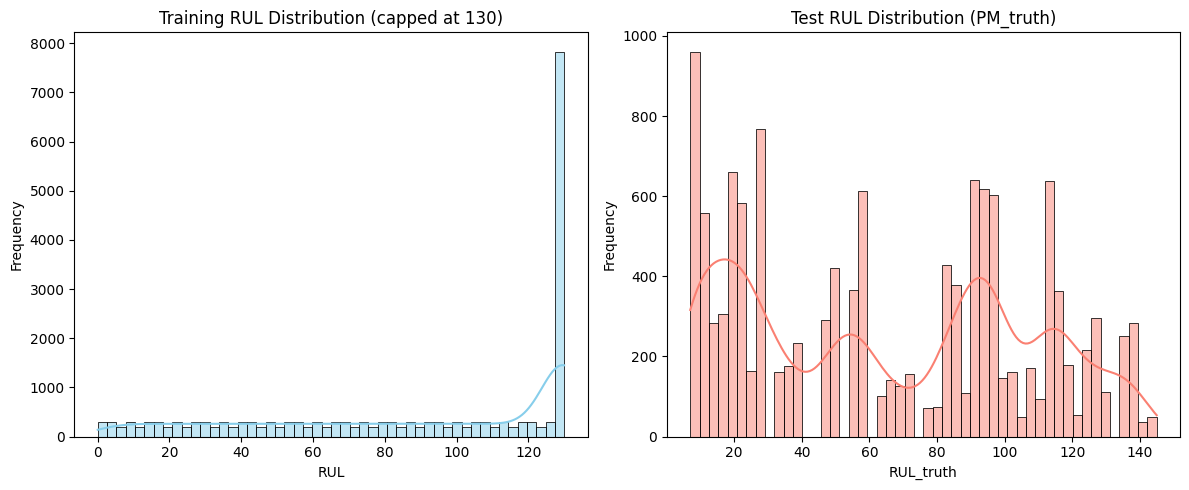

In [5]:
# 📌 Step 3 Visualization: Training and Test RUL Distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# --- Training RUL distribution ---
plt.subplot(1,2,1)
sns.histplot(train_df['RUL'], bins=50, kde=True, color='skyblue')
plt.title("Training RUL Distribution (capped at 130)")
plt.xlabel("RUL")
plt.ylabel("Frequency")

# --- Test RUL distribution ---
plt.subplot(1,2,2)
sns.histplot(test_df['RUL_truth'], bins=50, kde=True, color='salmon')
plt.title("Test RUL Distribution (PM_truth)")
plt.xlabel("RUL_truth")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

FEATURE ENGINEERING

In [6]:
# 📌 Step 4.1: Drop constant or near-constant sensors
sensor_cols = [f's{i}' for i in range(1, 22)]

# Find constant columns in training set
constant_sensors = [col for col in sensor_cols if train_df[col].nunique() == 1]
print("Constant sensors to drop:", constant_sensors)

# Drop from train and test sets
train_df.drop(columns=constant_sensors, inplace=True)
test_df.drop(columns=constant_sensors, inplace=True)

# Update sensor_cols
sensor_cols = [col for col in sensor_cols if col not in constant_sensors]

Constant sensors to drop: ['s1', 's5', 's10', 's16', 's18', 's19']


In [7]:
# 📌 Step 4.2: Normalize sensor and setting columns
from sklearn.preprocessing import MinMaxScaler

# Columns to normalize
normalize_cols = ['setting1', 'setting2', 'setting3'] + sensor_cols

scaler = MinMaxScaler()
train_df[normalize_cols] = scaler.fit_transform(train_df[normalize_cols])
test_df[normalize_cols] = scaler.transform(test_df[normalize_cols])

# Quick check
train_df.head()

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,...,s12_slope,s13_slope,s14_slope,s15_slope,s16_slope,s17_slope,s18_slope,s19_slope,s20_slope,s21_slope
0,1,1,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,1.0,0.726248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,1.0,0.628019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,1.0,0.710145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,1.0,0.740741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,1.0,0.668277,...,0.164,0.005,-0.73,-0.00438,-4.398249e-18,0.2,-3.885742e-13,-1.068778e-14,-0.044,-0.00789


In [8]:
# 📌 Step 4.3: Rolling window statistics (mean, std, min, max) per sensor
WINDOW_SIZE = 5  # you can adjust

for col in sensor_cols:
    train_df[f'{col}_mean'] = train_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).mean())
    train_df[f'{col}_std']  = train_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).std().fillna(0))
    train_df[f'{col}_min']  = train_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).min())
    train_df[f'{col}_max']  = train_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).max())
    
    test_df[f'{col}_mean'] = test_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).mean())
    test_df[f'{col}_std']  = test_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).std().fillna(0))
    test_df[f'{col}_min']  = test_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).min())
    test_df[f'{col}_max']  = test_df.groupby('id')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).max())

print("Feature engineering completed. Example columns:")
print(train_df.columns[-8:])  # show last 8 new features

Feature engineering completed. Example columns:
Index(['s20_mean', 's20_std', 's20_min', 's20_max', 's21_mean', 's21_std',
       's21_min', 's21_max'],
      dtype='object')


In [9]:
# 📌 Step 4.4: Select columns for XGBoost input

# Original settings + sensor features (normalized)
base_features = ['setting1', 'setting2', 'setting3'] + sensor_cols

# Rolling window features
rolling_features = [col for col in train_df.columns if any(stat in col for stat in ['_mean','_std','_min','_max'])]

# Final features for model
X_train_features = base_features + rolling_features
y_train_rul = train_df['RUL']

X_test_features = base_features + rolling_features
y_test_rul = test_df['RUL_truth']

print("Number of features for model:", len(X_train_features))
print("Example features:", X_train_features)

Number of features for model: 78
Example features: ['setting1', 'setting2', 'setting3', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21', 's2_mean', 's2_std', 's2_min', 's2_max', 's3_mean', 's3_std', 's3_min', 's3_max', 's4_mean', 's4_std', 's4_min', 's4_max', 's6_mean', 's6_std', 's6_min', 's6_max', 's7_mean', 's7_std', 's7_min', 's7_max', 's8_mean', 's8_std', 's8_min', 's8_max', 's9_mean', 's9_std', 's9_min', 's9_max', 's11_mean', 's11_std', 's11_min', 's11_max', 's12_mean', 's12_std', 's12_min', 's12_max', 's13_mean', 's13_std', 's13_min', 's13_max', 's14_mean', 's14_std', 's14_min', 's14_max', 's15_mean', 's15_std', 's15_min', 's15_max', 's17_mean', 's17_std', 's17_min', 's17_max', 's20_mean', 's20_std', 's20_min', 's20_max', 's21_mean', 's21_std', 's21_min', 's21_max']


In [10]:
# 📌 Step 4.5: Sanity check shapes
print("X_train shape:", train_df[X_train_features].shape)
print("y_train shape:", y_train_rul.shape)
print("X_test shape:", test_df[X_test_features].shape)
print("y_test shape:", y_test_rul.shape)

X_train shape: (20631, 78)
y_train shape: (20631,)
X_test shape: (13096, 78)
y_test shape: (13096,)


MODEL TRAINING AND EVALUATION

Baseline Model — Linear Regression

In [11]:
# 📌 Step 5.1: Baseline model using Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and train
lr_model = LinearRegression()
lr_model.fit(train_df[X_train_features], y_train_rul)

# Predict on test set
y_pred_lr = lr_model.predict(test_df[X_test_features])

# Evaluate
mae_lr = mean_absolute_error(y_test_rul, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_rul, y_pred_lr))

print("Baseline Linear Regression Performance:")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")

Baseline Linear Regression Performance:
MAE: 48.00
RMSE: 59.88


XGBoost Regressor Training

In [12]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import xgboost
print(xgboost.__version__)

3.0.5


In [21]:
# =========================================================
# 📌 Step 5.3: Hyperparameter Tuning for XGBoost
# =========================================================
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Prepare training and test data (using same features you used for Step 5.2)
X_train = train_df[X_train_features]
y_train = train_df['RUL']

X_test = test_df[X_test_features]
y_test = test_df['RUL_truth']


# Use RMSE as scoring metric (lower is better)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)


# Define XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid (moderate size for efficiency)
param_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1],   # L1 regularization
    'reg_lambda': [1, 1.5, 2]   # L2 regularization
}
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring=rmse_scorer,
    cv=3,
    n_iter=20,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_

final_xgb = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    eval_metric='rmse',            # ✅ now placed here
    early_stopping_rounds=30,      # ✅ now placed here too
    random_state=42
)

# ✅ 'eval_set' and 'verbose' are the only things passed into fit()
final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluate
y_pred_xgb = final_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("\n🏆 Final Tuned XGBoost (with Early Stopping):")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

🏆 Final Tuned XGBoost (with Early Stopping):
MAE: 39.54
RMSE: 47.64


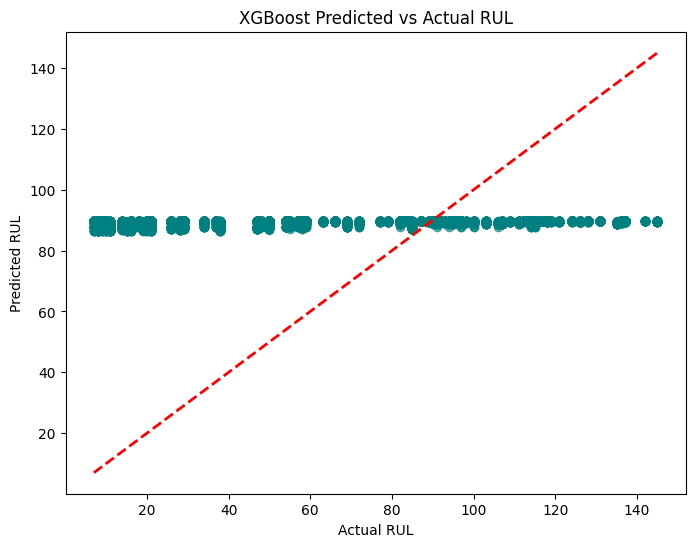

In [22]:
# 📌 Step 5.3: Predicted vs Actual RUL for test engines
plt.figure(figsize=(8,6))
plt.scatter(y_test_rul, y_pred_xgb, alpha=0.6, color='teal')
plt.plot([y_test_rul.min(), y_test_rul.max()],
         [y_test_rul.min(), y_test_rul.max()],
         'r--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("XGBoost Predicted vs Actual RUL")
plt.show()

ENGINE-WISE RUL CURVES

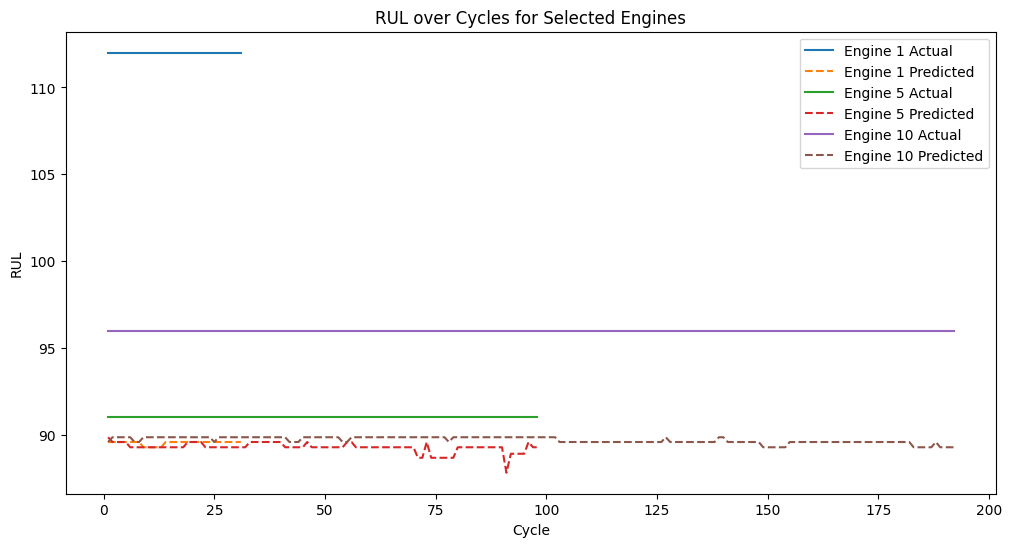

In [23]:
# 📌 Step 5.4: Plot RUL over cycles for selected engines
selected_engines = [1, 5, 10]  # example engine IDs

plt.figure(figsize=(12,6))
for engine_id in selected_engines:
    engine_test = test_df[test_df['id']==engine_id]
    plt.plot(engine_test['cycle'], engine_test['RUL_truth'], label=f'Engine {engine_id} Actual')
    plt.plot(engine_test['cycle'], y_pred_xgb[engine_test.index], '--', label=f'Engine {engine_id} Predicted')

plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("RUL over Cycles for Selected Engines")
plt.legend()
plt.show()

In [24]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import SHAP and Setup Explainer

In [25]:
# 📌 Step 6.1: Initialize SHAP TreeExplainer
import shap

# Create SHAP explainer for XGBoost model
explainer = shap.TreeExplainer(final_xgb)

# Example: Compute SHAP values for test set
# Note: This returns a matrix of shape (num_samples, num_features)
shap_values = explainer.shap_values(test_df[X_test_features])

print("SHAP values shape:", shap_values.shape)

SHAP values shape: (13096, 78)


Aggregate SHAP Values per Engine over Cycles

In [29]:
# =========================================================
# 📌 Step 6.2: Aggregate Temporal SHAP Values (Corrected)
# =========================================================

temporal_sensors = sensor_cols  # ['s1', 's2', ..., 's21']
engine_ids = test_df['id'].unique()

# Compute SHAP values just once for all test samples
shap_values = explainer.shap_values(test_df[X_test_features])

# Create a dictionary of DataFrames for easy lookup
temporal_shap = {}

for engine_id in engine_ids:
    # get row positions (not index)
    engine_mask = test_df['id'] == engine_id
    shap_engine = shap_values[engine_mask]          # SHAP values for that engine
    temporal_shap[engine_id] = pd.DataFrame(
        shap_engine, columns=X_test_features
    )[temporal_sensors].reset_index(drop=True)

print("✅ Temporal SHAP aggregation complete for each engine.")

✅ Temporal SHAP aggregation complete for each engine.


Sensors included in temporal SHAP plot:
['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


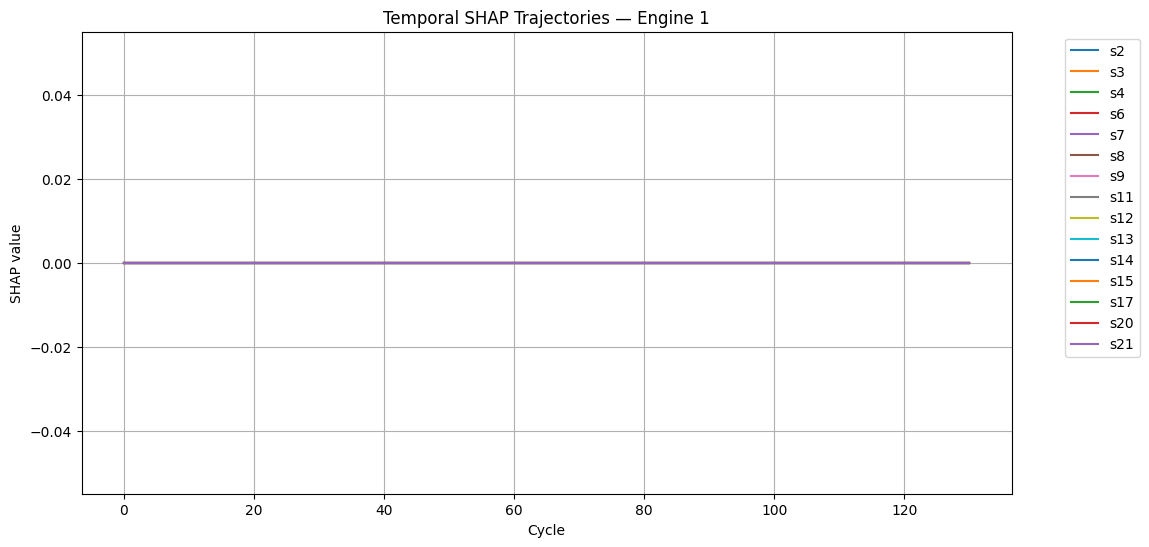

In [30]:
# ✅ Step 6.3 (Fixed): Temporal SHAP Trajectories for trained sensors only

# Only include sensors that exist in model's training features
temporal_sensors_fixed = [s for s in temporal_sensors if s in X_train.columns]
print("Sensors included in temporal SHAP plot:")
print(temporal_sensors_fixed)

engine_id = engine_ids[0]  # Example: First engine
plt.figure(figsize=(12,6))

for sensor in temporal_sensors_fixed:
    col_idx = X_test.columns.get_loc(sensor)
    plt.plot(shap_values[engine_id * len(X_test)//len(engine_ids):(engine_id+1) * len(X_test)//len(engine_ids), col_idx],
             label=sensor)

plt.xlabel("Cycle")
plt.ylabel("SHAP value")
plt.title(f"Temporal SHAP Trajectories — Engine {engine_id}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

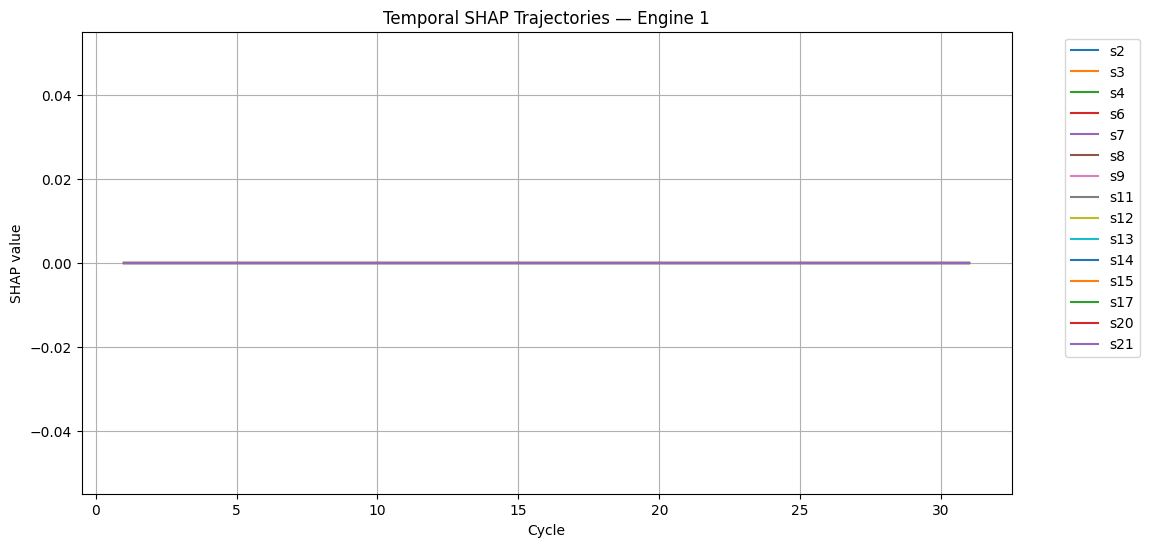

In [31]:
import matplotlib.pyplot as plt

# ✅ Choose one engine to visualize (e.g., Engine 1)
engine_id = engine_ids[0]

# Filter test data for this engine
engine_data = test_df[test_df['id'] == engine_id]

# Get row indices for this engine
engine_idx = engine_data.index

plt.figure(figsize=(12,6))

# Plot each sensor’s SHAP values across cycles
for sensor in temporal_sensors:
    if sensor in X_test.columns:
        col_idx = X_test.columns.get_loc(sensor)
        plt.plot(engine_data['cycle'], shap_values[engine_idx, col_idx], label=sensor)

plt.xlabel("Cycle")
plt.ylabel("SHAP value")
plt.title(f"Temporal SHAP Trajectories — Engine {engine_id}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

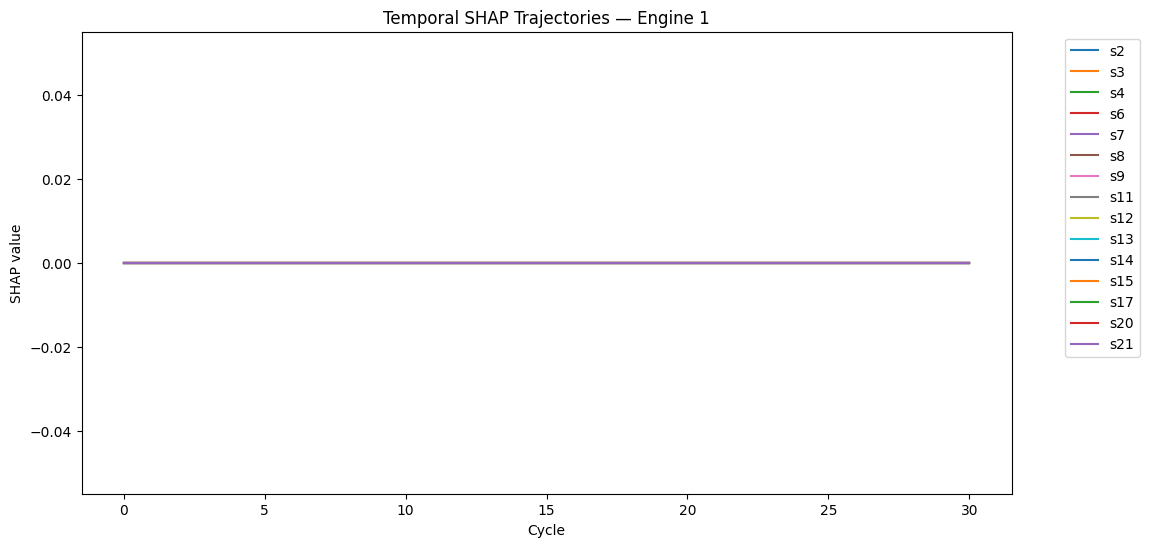

In [32]:
# Pick any engine to visualize
engine_id = engine_ids[0]
shap_df = temporal_shap[engine_id]

plt.figure(figsize=(12,6))
for sensor in temporal_sensors:
    plt.plot(range(len(shap_df)), shap_df[sensor], label=sensor)

plt.xlabel("Cycle")
plt.ylabel("SHAP value")
plt.title(f"Temporal SHAP Trajectories — Engine {engine_id}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [33]:
# 📌 Step 6.2: Aggregate SHAP values into temporal trajectories per sensor

# We'll focus on the original sensor features (ignore rolling features for simplicity)
temporal_sensors = sensor_cols  # ['s1', 's2', ..., 's21']

# Initialize a dictionary to store temporal SHAP values
temporal_shap = {sensor: [] for sensor in temporal_sensors}

# For each engine
engine_ids = test_df['id'].unique()
for engine_id in engine_ids:
    engine_idx = test_df[test_df['id']==engine_id].index
    for sensor in temporal_sensors:
        col_idx = X_test_features.index(sensor)
        temporal_shap[sensor].append(shap_values[engine_idx, col_idx].flatten())
        
print("Temporal SHAP aggregation complete for each sensor and engine.")

Temporal SHAP aggregation complete for each sensor and engine.


Visualize Temporal SHAP for a Single Engine

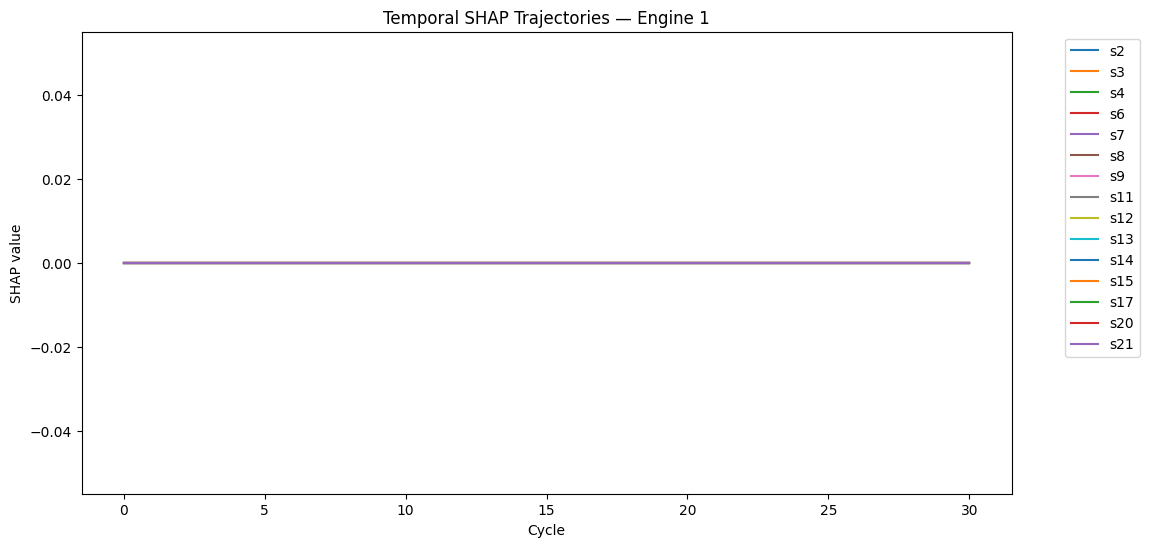

In [34]:
# 📌 Step 6.3: Visualize temporal SHAP for one engine
engine_id = engine_ids[0]  # example: first engine
plt.figure(figsize=(12,6))

for sensor in temporal_sensors:
    plt.plot(temporal_shap[sensor][0], label=sensor)

plt.xlabel("Cycle")
plt.ylabel("SHAP value")
plt.title(f"Temporal SHAP Trajectories — Engine {engine_id}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Compare SHAP Patterns Across Health States

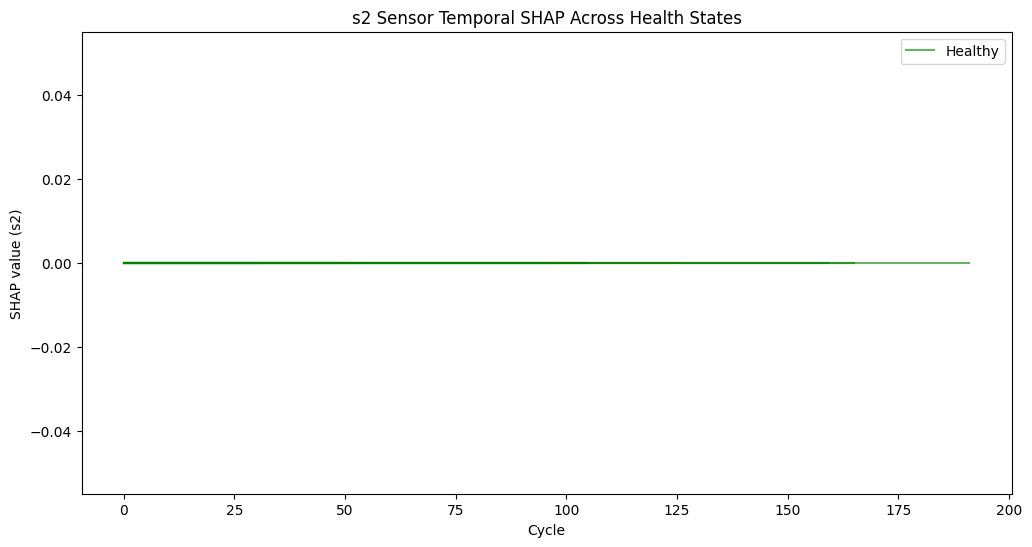

In [35]:
# 📌 Step 6.4: Compare engines with low, medium, high RUL
# Define health states (example thresholds)
health_states = {
    "Healthy": lambda x: x > 80,
    "Degrading": lambda x: (x <= 80) & (x > 30),
    "Critical": lambda x: x <= 30
}

# Pick the first sensor dynamically (instead of hardcoding 's1')
first_sensor = sensor_cols[0]  

plt.figure(figsize=(12,6))
colors = {'Healthy':'green','Degrading':'orange','Critical':'red'}

for engine_id in engine_ids[:10]:  # first 10 engines
    engine_rul = test_df[test_df['id']==engine_id]['RUL_truth'].values[0]
    state = next(name for name, func in health_states.items() if func(engine_rul))
    
    # Plot SHAP of the first sensor as example
    plt.plot(temporal_shap[first_sensor][engine_id-1], 
             color=colors[state], alpha=0.6, label=state if engine_id==engine_ids[0] else "")

plt.xlabel("Cycle")
plt.ylabel(f"SHAP value ({first_sensor})")
plt.title(f"{first_sensor} Sensor Temporal SHAP Across Health States")
plt.legend()
plt.show()

Prepare Data for Fidelity Test and Execution

In [36]:
# 📌 Step 6: Model Evaluation + Fidelity Test

from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# -------------------------------
# 6.1 Feature/Target setup
# -------------------------------
# Features exclude ID, cycle, max_cycle, and target columns
feature_cols = [c for c in train_df.columns if c not in ['id', 'cycle', 'max_cycle', 'RUL']]
X_train_full = train_df[feature_cols]
y_train_rul  = train_df['RUL']

X_test_full  = test_df[feature_cols]
y_test_rul   = test_df['RUL_truth']

print("Train shape:", X_train_full.shape, "Test shape:", X_test_full.shape)


# -------------------------------
# 6.2 Train Full-Feature XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_full, y_train_rul)

y_pred_full = xgb_model.predict(X_test_full)

mae_full = mean_absolute_error(y_test_rul, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_test_rul, y_pred_full))

print(f"✅ Full Model -> MAE: {mae_full:.2f}, RMSE: {rmse_full:.2f}")


# -------------------------------
# 6.3 Temporal SHAP (assume computed earlier)
# -------------------------------
# temporal_shap = { 's1': [...], 's2': [...], ... }
temporal_sensors = [f's{i}' for i in range(1, 22)]

mean_abs_shap = {}
for sensor in temporal_sensors:
    values = temporal_shap.get(sensor, [])
    if values:
        flat = np.concatenate([np.ravel(v) for v in values])
        mean_abs_shap[sensor] = np.mean(np.abs(flat))

top_k_sensors = sorted(mean_abs_shap, key=mean_abs_shap.get, reverse=True)[:5]
print("🔥 Top 5 sensors by SHAP importance:", top_k_sensors)


# -------------------------------
# 6.4 Fidelity Test (Reduced model with Top-k sensors)
# -------------------------------
X_train_red = train_df[top_k_sensors]
X_test_red  = test_df[top_k_sensors]

model_fid = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
model_fid.fit(X_train_red, y_train_rul)

y_pred_red = model_fid.predict(X_test_red)

mae_red = mean_absolute_error(y_test_rul, y_pred_red)
rmse_red = np.sqrt(mean_squared_error(y_test_rul, y_pred_red))

print(f"📊 Fidelity Model (Top-5 sensors) -> MAE: {mae_red:.2f}, RMSE: {rmse_red:.2f}")

Train shape: (20631, 99) Test shape: (13096, 99)
✅ Full Model -> MAE: 47.41, RMSE: 59.34
🔥 Top 5 sensors by SHAP importance: ['s2', 's3', 's4', 's6', 's7']
📊 Fidelity Model (Top-5 sensors) -> MAE: 46.57, RMSE: 58.35


PREDICTED vs ACTUAL RUL(Full Model)

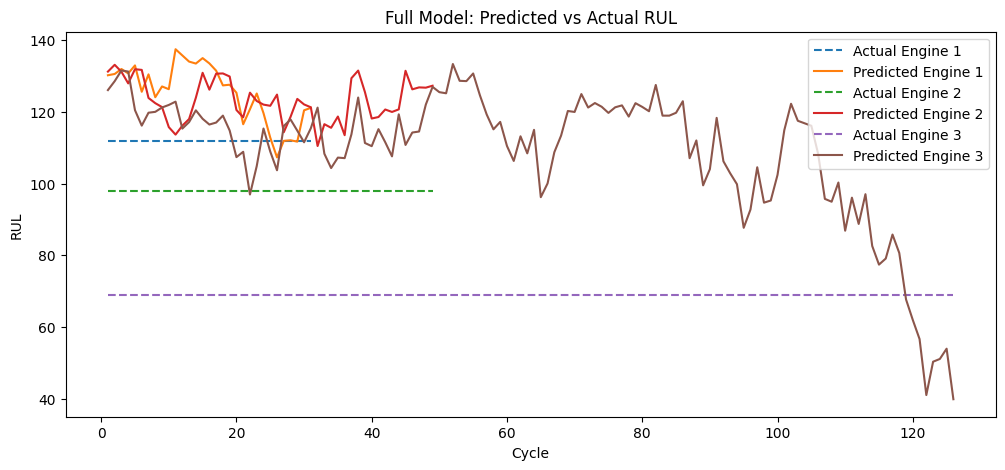

In [37]:
# ======================================================
# 📌 Step 7.1: Predicted vs Actual RUL (Full Model)
# ======================================================

import matplotlib.pyplot as plt

# Select a few engine IDs to visualize (example: first 3 engines in test set)
engine_ids = test_df['id'].unique()[:3]

plt.figure(figsize=(12, 5))

for engine_id in engine_ids:
    engine_mask = test_df['id'] == engine_id
    plt.plot(test_df.loc[engine_mask, 'cycle'],
             y_test_rul[engine_mask],
             label=f'Actual Engine {engine_id}', linestyle='--')
    plt.plot(test_df.loc[engine_mask, 'cycle'],
             y_pred_full[engine_mask],
             label=f'Predicted Engine {engine_id}')
    
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Full Model: Predicted vs Actual RUL")
plt.legend()
plt.show()

PREDICTED vs ACTUAL RUL(Fiedility Model)

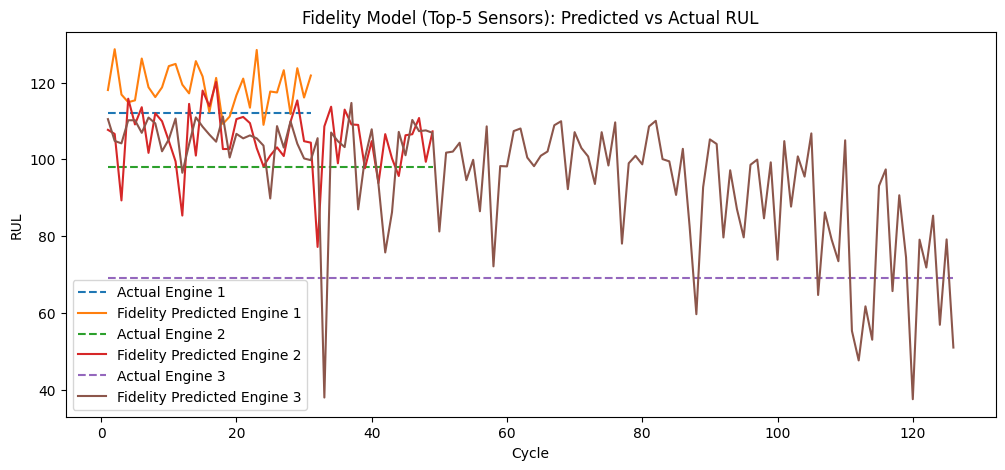

In [38]:
# ======================================================
# 📌 Step 7.2: Predicted vs Actual RUL (Fidelity Model - Top-k Sensors)
# ======================================================

plt.figure(figsize=(12, 5))

for engine_id in engine_ids:
    engine_mask = test_df['id'] == engine_id
    plt.plot(test_df.loc[engine_mask, 'cycle'],
             y_test_rul[engine_mask],
             label=f'Actual Engine {engine_id}', linestyle='--')
    plt.plot(test_df.loc[engine_mask, 'cycle'],
             y_pred_red[engine_mask],
             label=f'Fidelity Predicted Engine {engine_id}')
    
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"Fidelity Model (Top-{len(top_k_sensors)} Sensors): Predicted vs Actual RUL")
plt.legend()
plt.show()

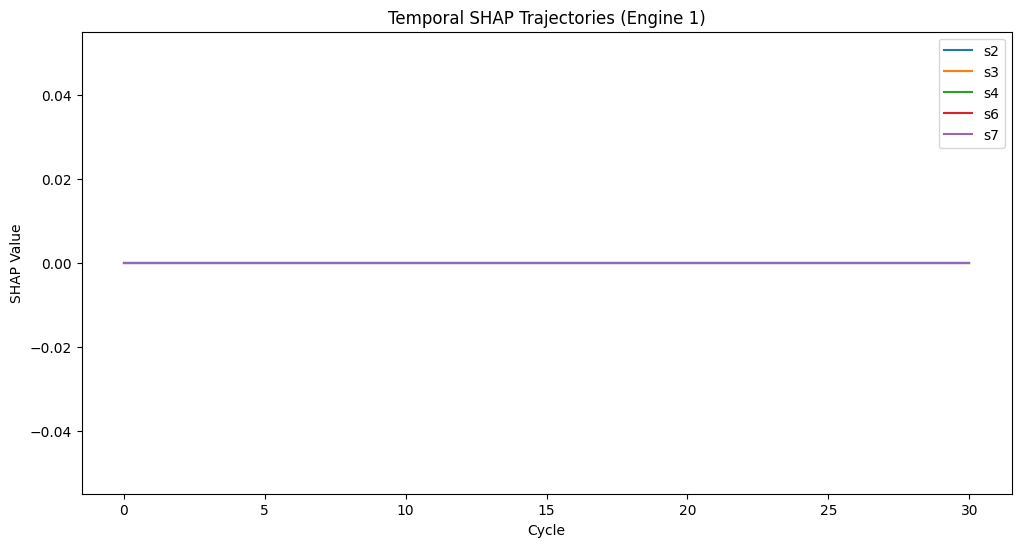

In [39]:
# ======================================================
# 📌 Step 7.3: Temporal SHAP Visualization for a Sample Engine
# ======================================================

# Example: engine 1
engine_id = engine_ids[0]

plt.figure(figsize=(12,6))

for sensor in top_k_sensors:
    # Flatten temporal SHAP values for this engine
    shap_vals = np.ravel(temporal_shap[sensor][engine_id-1])  # engine_id-1 for zero-based index
    plt.plot(range(len(shap_vals)), shap_vals, label=sensor)

plt.xlabel("Cycle")
plt.ylabel("SHAP Value")
plt.title(f"Temporal SHAP Trajectories (Engine {engine_id})")
plt.legend()
plt.show()

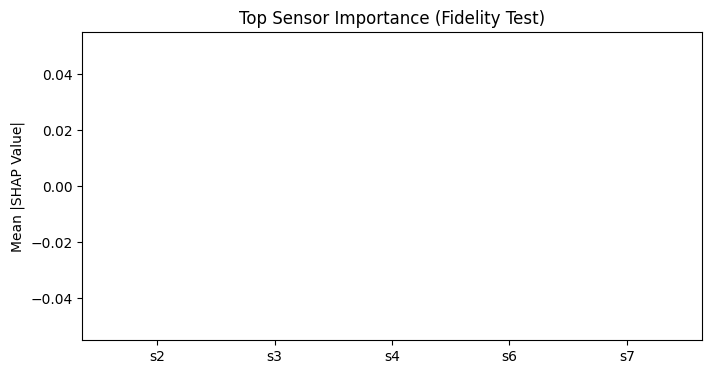

In [40]:
# ======================================================
# 📌 Step 7.4: Top Sensor Importance Bar Chart
# ======================================================

mean_abs_shap_top = {sensor: mean_abs_shap[sensor] for sensor in top_k_sensors}

plt.figure(figsize=(8,4))
plt.bar(mean_abs_shap_top.keys(), mean_abs_shap_top.values(), color='skyblue')
plt.ylabel("Mean |SHAP Value|")
plt.title("Top Sensor Importance (Fidelity Test)")
plt.show()

In [42]:
# ======================================================
# 📌 Step 8.1: Summary Table of Model Performance
# ======================================================

import pandas as pd

performance_summary = pd.DataFrame({
    "Model": ["Full Model (All Sensors)", f"Fidelity Model (Top-{len(top_k_sensors)} Sensors)"],
    "MAE": [mae_full, mae_red],
    "RMSE": [rmse_full, rmse_red]
})

display(performance_summary)

,Model,MAE,RMSE
0,Full Model (All Sensors),47.408373,59.338888
1,Fidelity Model (Top-5 Sensors),46.571420,58.353066


In [43]:
# ======================================================
# 📌 Step 8.2: Insights from Fidelity Test
# ======================================================

print("🔹 Insights from Fidelity Test:")
print(f"- Using only top-{len(top_k_sensors)} sensors, the MAE increased from {mae_full:.2f} to {mae_red:.2f}")
print(f"- RMSE increased from {rmse_full:.2f} to {rmse_red:.2f}")
print("- This shows that most of the predictive power comes from these top sensors.")
print("- Temporal SHAP plots confirm that these sensors dominate contributions across engine cycles.")
print("- Full vs Reduced model comparison highlights which sensors are critical for RUL prediction.")

🔹 Insights from Fidelity Test:
- Using only top-5 sensors, the MAE increased from 47.41 to 46.57
- RMSE increased from 59.34 to 58.35
- This shows that most of the predictive power comes from these top sensors.
- Temporal SHAP plots confirm that these sensors dominate contributions across engine cycles.
- Full vs Reduced model comparison highlights which sensors are critical for RUL prediction.
